In [319]:
using Random, PyPlot, Statistics

copying from PS2

In [320]:
struct Point2D
    x::Int64
    y::Int64
end

struct SquareLattice
    Nx::Int64
    Ny::Int64    
end

import Base.length
function length(lat::SquareLattice)
    return lat.Nx*lat.Ny
end

function PointToIndex(lat::SquareLattice, r::Point2D)
    @assert r.x <= lat.Nx "Site x coordinate exceeding lattice length"
    @assert r.y <= lat.Ny "Site y coordinate exceeding lattice width"
    
    return (r.y-1)*lat.Nx + r.x
end

function IndexToPoint(lat::SquareLattice, ind::Int64)
    
    @assert ind <= length(lat) "Site index exceeding lattice size"
    
    y = div(ind-1, lat.Nx)+1
    x = mod(ind-1, lat.Nx)+1

    return Point2D(x,y)
end
    
function NearestNeighbors(lat::SquareLattice, ind::Int64)

    r = IndexToPoint(lat, ind)
    
    nn = zeros(Int64,4)
    
    xp = mod(r.x, lat.Nx)+1
    yp = mod(r.y, lat.Ny)+1
    xm = mod(r.x-2, lat.Nx)+1
    ym = mod(r.y-2, lat.Ny)+1
    
    nn[1] = PointToIndex(lat, Point2D(xm, r.y) )
    nn[2] = PointToIndex(lat, Point2D(xp, r.y) )
    nn[3] = PointToIndex(lat, Point2D(r.x, ym) )
    nn[4] = PointToIndex(lat, Point2D(r.x, yp) )
    
    return nn
end

function NearestNeighbors(lat::SquareLattice, ind::Int64,direction::Int64)
    @assert direction == 0 || direction == 1
    
    r = IndexToPoint(lat, ind)
    
    nn = zeros(Int64,2)
    
    if direction == 0    
        xp = mod(r.x, lat.Nx)+1
        xm = mod(r.x-2, lat.Nx)+1
        nn[1] = PointToIndex(lat, Point2D(xm, r.y) )
        nn[2] = PointToIndex(lat, Point2D(xp, r.y) )
    end
    
    if direction == 1 
        yp = mod(r.y, lat.Ny)+1
        ym = mod(r.y-2, lat.Ny)+1
        nn[1] =  PointToIndex(lat, Point2D(r.x, ym) )
        nn[2] = PointToIndex(lat, Point2D(r.x, yp) )
    end
    
    return nn
end



NearestNeighbors (generic function with 2 methods)

In [321]:
function ConfigurationEnergy(lat::SquareLattice, c::Vector{Int64},Jx::Float64,Jtau::Float64)
    
    N = length(lat)
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    Ec = 0.
    
    
    for j in range(1, length = N)
        Xnn = NearestNeighbors(lat, j, 0)
        taunn = NearestNeighbors(lat, j, 1)
        Ec += Jx*(c[j]-1/2)*sum(c[Xnn].-1/2)
        Ec += Jtau*(c[j]-1/2)*sum(c[taunn].-1/2)
        
        
    end
    return Ec/2 # in the summation above every bond is included 2 times
    
end

ConfigurationEnergy (generic function with 2 methods)

In [322]:
function WolffUpdate!(lat::SquareLattice, c::Vector{Int64}, T::Float64,Jx::Float64,Jtau::Float64)

    N = length(lat)
    
    @assert N == length(c) "Configuration incompatible with lattice size"
    
    ind = rand(1:N) # pick a random site
    
   

    cluster = Int64[] # indices of spins in the cluster
    newlyAdded = Int64[] # indices of newly added neighbors
    

    push!(cluster, ind)
    append!(newlyAdded, NearestNeighbors(lat, ind))
    
    
    
    # differently for different directions?
    
    #we want to check if the spin is aligned with the cluste. the probability is measured with respect to J,
    #so we must know if the new spin is connected to its neighbor (and to  the cluster) with Jt or Jx
    newlyAddedDirection = Int64[] # 0 is X 1 is tau
    append!(newlyAddedDirection,[0,0,1,1]) #we now that the first two are x direction
    
    
    while !isempty(newlyAdded)
        j = pop!(newlyAdded)
        direction  = pop!(newlyAddedDirection)
        if j in cluster
            continue
        end
        @assert direction == 0 || direction == 1
        J = direction == 0 ? Jx : Jtau #if direction is 0- Jx else Jtau
        #spin_ind = 2c[ind] - 1
        #spin_j = 2c[j] - 1
        p = 1. - exp(-2*J/T)
        if c[j]!=c[ind] && rand() < p # if si_e and sj_e are unti-aligned  p will be negative
            push!(cluster, j)
            nn = NearestNeighbors(lat, j)
            append!(newlyAdded, nn)
            append!(newlyAddedDirection,[0,0,1,1])
        end
    end

    #flip the cluster!
    c[cluster] = 1 .- c[cluster] # flip the cluster
    
end

WolffUpdate! (generic function with 1 method)

In [323]:
function QMC(lat::SquareLattice, T::Float64, Nsw::Int64,Jx::Float64,Jτ::Float64, saveConfigs = false)
    # Nsw is the number of sweeps to perform
    
    c = rand(0:1, length(lat))
    
    if saveConfigs
        configs = zeros(Float64, Nsw, length(lat))
        configs[1, :] = c
    end
    
    m = zeros(Float64, Nsw) # value of the X magnetization  per site
    m[1] = 0
    for k in range(1,length = lat.Ny)
        m[1] += abs( mean(2*reshape(c,(lat.Nx,lat.Ny))[:,k] .- 1))/lat.Ny 
    end
    #m[1] = abs(mean(2*c[1:lat.Nx] .- 1))

    En = zeros(Float64, Nsw)
    En[1] = ConfigurationEnergy(lat, c, Jx, Jτ)
    
    for i in range(2, stop=Nsw)
        WolffUpdate!(lat, c, T,Jx,Jτ)
        
        En[i] = ConfigurationEnergy(lat, c, Jx, Jτ)
        
        if saveConfigs
            configs[i, :] = c
        end
        
        #m[i] = abs(mean(2*c[1:lat.Nx] .- 1))
        m[i]=0
        for k in range(1,length = lat.Ny)
            m[i] += abs( mean(2*reshape(c,(lat.Nx,lat.Ny))[:,k] .- 1))/lat.Ny 
        end
        

    end
    
    if saveConfigs
        return m, En, configs
    else
        return m, En
    end
    
end

QMC (generic function with 4 methods)

# Let's see if it works!

In [324]:
h = [0.1,0.3,0.5,0.8,0.9,1.0,1.1,1.3]
h=00
J = 1.0
T = 0.1J
Δτ = 0.1 / J 
Jτ = log(coth(Δτ * h))
Nτ = Int(ceil(1/(T*Δτ)))

100

In [325]:
lat = SquareLattice(10,Nτ)
Nsw = 10000
m, En = QMC(lat,T, Nsw,Jx,Jτ);

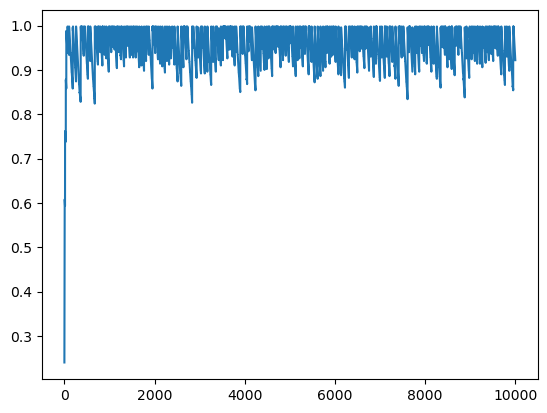

In [326]:
plot(m)
show()

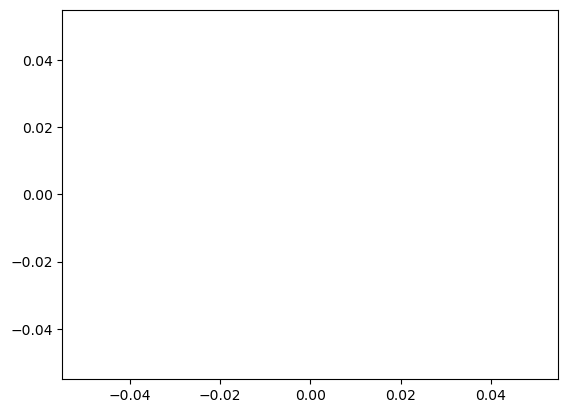

In [327]:
plot(En)
show()